## Correlation Analysis
In this notebook, we try to check if there's any correlation between the 6 measurements, as well as correlation between measurements and geography(latitude, longitude, elevation). 

I'm using the monthly smoothed data as it has much less noise and can be very well explained by its eigen decomposition. More details is in notebook '4.4 Weather Analysis - Visualisation-monthly'

And further more, we reduce the 12 dimension vector(12 months) to 3 eigen coefficients for each data sample, as we saw in 4.4 notebook that top 3 eigen vectors can represent 80% variance of original 12 dimension dataset.

So the correlation we finally found reflects more general relation between measurements in yearly basis.

In [2]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSBBB'

## Load the required libraries

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File and monthly average data

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_monthly_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))

# Read data file into a spark DataFrame
filename=data_dir+'/US_Weather_monthly_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [19]:
def decompose(row, mean=None, v=None):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [34]:
from functools import partial

k=4

df_all = {}
for m in STAT.keys():
    df=df_in.filter(df_in.measurement==m)

    EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
    Mean=STAT[m]['Mean']
    v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

    rdd2=df.rdd.map(partial(decompose, mean=Mean, v=v))
    df2=sqlContext.createDataFrame(rdd2)
    df3=df2.filter(df2.res_mean<1)
    # Sort entries by increasing values of ers_3
    #df3=df3.sort(df3.res_3,ascending=True)
    df_all[m] = df3
    sqlContext.registerDataFrameAsTable(df3,'weather_%s'%(m)) #using older sqlContext instead of newer (V2.0) sparkSession


In [32]:
df_all['TMIN'].take(1)

[Row(coeff_1=-87.88699972935609, coeff_2=26.826168262201755, coeff_3=3.0644293891956673, coeff_4=-12.098336479735648, elevation=1340.2, label=u'SSSBSBBB', latitude=39.5236, longitude=-119.7386, measurement=u'TMIN', res_1=0.2311279181338304, res_2=0.15949343979228026, res_3=0.1585586713299319, res_4=0.1439887860597298, res_mean=0.14454546189937156, station=u'USC00267693', total_var=69500.9474029541, undefs=17, vector=bytearray(b'k\xd2\xa7\xcf\x07\xcd\xa5P\xefR\x1eW\xd6X\xa0W\x96U\x87N\xa5\xc5\xf2\xcd'), year=2002.0)]

In [33]:
for m in df_all.keys():
    print m,df_all[m].count()

TMIN 2630
TOBS 1191
TMAX 2668
SNOW 1119
SNWD 517
PRCP 1694


In [21]:
for m in df_all.keys():
    filename=data_dir+'/decon_'+file_index+'_monthly_'+m+'.parquet'
    !rm -rf $filename
    df_all[m].write.parquet(filename)
!du -sh $data_dir/*.parquet

4.3M	../../Data/Weather/US_Weather_SSSBSBBB.parquet
361K	../../Data/Weather/US_Weather_monthly_SSSBSBBB.parquet
2.8M	../../Data/Weather/decon_SSSBSBBB_PRCP.parquet
2.0M	../../Data/Weather/decon_SSSBSBBB_SNOW.parquet
2.0M	../../Data/Weather/decon_SSSBSBBB_SNWD.parquet
3.6M	../../Data/Weather/decon_SSSBSBBB_TMIN.parquet
2.8M	../../Data/Weather/decon_SSSBSBBB_TOBS.parquet
2.0M	../../Data/Weather/decon_SSSBSBBB_monthly_PRCP.parquet
2.0M	../../Data/Weather/decon_SSSBSBBB_monthly_SNOW.parquet
2.0M	../../Data/Weather/decon_SSSBSBBB_monthly_SNWD.parquet
2.0M	../../Data/Weather/decon_SSSBSBBB_monthly_TMAX.parquet
2.0M	../../Data/Weather/decon_SSSBSBBB_monthly_TMIN.parquet
2.0M	../../Data/Weather/decon_SSSBSBBB_monthly_TOBS.parquet


      0 [main] du 13216 find_fast_cwd: WARNING: Couldn't compute FAST_CWD pointer.  Please report this problem to
the public mailing list cygwin@cygwin.com


In [29]:
from functools import reduce
from pyspark.sql import DataFrame

df_merged = reduce(DataFrame.unionAll, df_all.values())

In [31]:
# check total valid data samples
df_merged.count()

9819

In [53]:
# We want to select samples of (year,station) pair that we have all 6 measurements in the year for the station.
# Basically, we join the 6 measurement tables on having same year and station
query = 'SELECT TMIN.year,TMIN.station,TMIN.latitude,TMIN.longitude,TMIN.elevation,'
columns = []
tables = []
conditions = []
for m in df_all.keys():
    tables.append("weather_%s as %s"%(m,m))
    columns.append("%s.coeff_1 %s_c1,%s.coeff_2 %s_c2,%s.coeff_3 %s_c3" % (m,m,m,m,m,m))
    conditions.append("%s.station = TMIN.station and %s.year = TMIN.year" % (m,m))
query += ','.join(columns)
query += "\nFROM " + ','.join(tables)
query += "\nWHERE " + ' AND '.join(conditions)
print query
df_join = sqlContext.sql(query)

SELECT TMIN.year,TMIN.station,TMIN.latitude,TMIN.longitude,TMIN.elevation,TMIN.coeff_1 TMIN_c1,TMIN.coeff_2 TMIN_c2,TMIN.coeff_3 TMIN_c3,TOBS.coeff_1 TOBS_c1,TOBS.coeff_2 TOBS_c2,TOBS.coeff_3 TOBS_c3,TMAX.coeff_1 TMAX_c1,TMAX.coeff_2 TMAX_c2,TMAX.coeff_3 TMAX_c3,SNOW.coeff_1 SNOW_c1,SNOW.coeff_2 SNOW_c2,SNOW.coeff_3 SNOW_c3,SNWD.coeff_1 SNWD_c1,SNWD.coeff_2 SNWD_c2,SNWD.coeff_3 SNWD_c3,PRCP.coeff_1 PRCP_c1,PRCP.coeff_2 PRCP_c2,PRCP.coeff_3 PRCP_c3
FROM weather_TMIN as TMIN,weather_TOBS as TOBS,weather_TMAX as TMAX,weather_SNOW as SNOW,weather_SNWD as SNWD,weather_PRCP as PRCP
WHERE TMIN.station = TMIN.station and TMIN.year = TMIN.year AND TOBS.station = TMIN.station and TOBS.year = TMIN.year AND TMAX.station = TMIN.station and TMAX.year = TMIN.year AND SNOW.station = TMIN.station and SNOW.year = TMIN.year AND SNWD.station = TMIN.station and SNWD.year = TMIN.year AND PRCP.station = TMIN.station and PRCP.year = TMIN.year


In [73]:
eg =df_join.take(3)
eg[0]

Row(year=1974.0, station=u'USC00049043', latitude=39.3331, longitude=-120.173, elevation=1774.9, TMIN_c1=177.2488880751196, TMIN_c2=-20.684097096211065, TMIN_c3=-2.074978393696064, TOBS_c1=72.20981554645108, TOBS_c2=149.38313534011996, TOBS_c3=-165.16559384290116, TMAX_c1=-47.081936012565144, TMAX_c2=38.51463890780574, TMAX_c3=48.84012881147185, SNOW_c1=16.423120853258176, SNOW_c2=-3.1110640463594965, SNOW_c3=-5.794905554206382, SNWD_c1=789.6842416705049, SNWD_c2=-24.77584030417671, SNWD_c3=-221.60024309025715, PRCP_c1=-12.191128511004306, PRCP_c2=-7.381525859055953, PRCP_c3=-4.780803529799169)

In [56]:
# check the total valid samples which has all 6 measurements in single year
df_join.count()

249

In [59]:
# convert to pandas dataframe, and select various interesting features to check
data_join = df_join.toPandas()
data_join1 = data_join.ix[:,['longitude','elevation','TMIN_c1', 'TOBS_c1','TMAX_c1','SNOW_c1','SNWD_c1','PRCP_c1']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001256B470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000104FEB00>]], dtype=object)

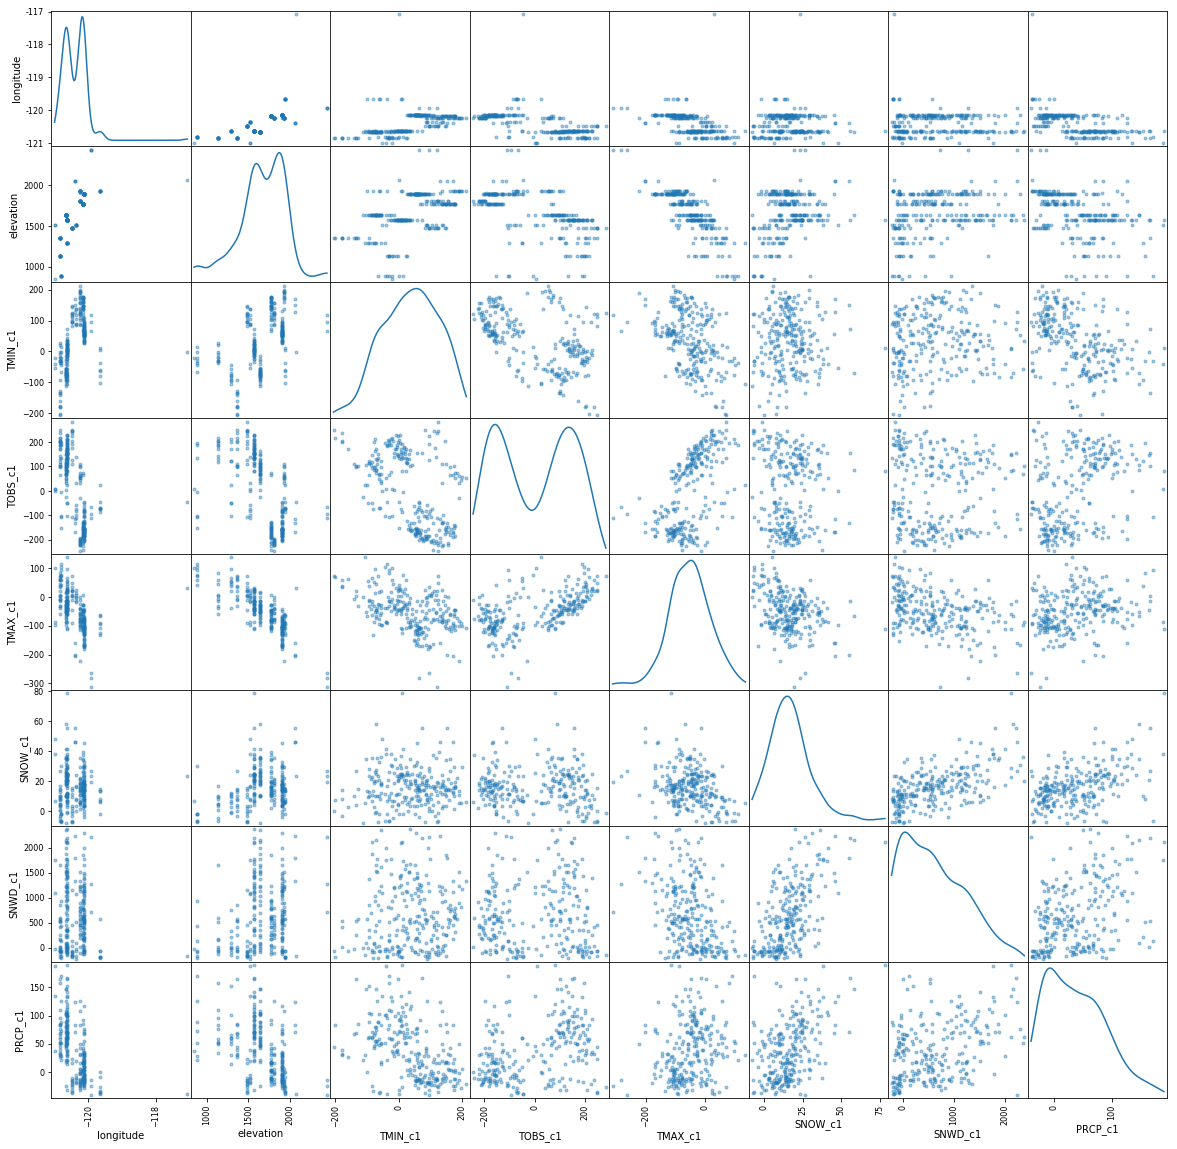

In [81]:
# plotting scatter_matrix to check correlation btw features
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data_join1,alpha=0.4,figsize=(20, 20), diagonal='kde')

### Conclusion from coeff_1 correlation
As above plotting, we only show the coeff_1 for each measurement since c1 alone can represent 60% of the variance of monthly data. Even with just 249 valid samples, I can still see some correlation btw different measurements as stated below.
* The 3 temperature measurements TMIN, TMAX, TOBS are positively correlated as expected intuitively.
* (SNOW,SNWD) and (SNOW,PRCP) are strongly positively corrected, and SNWD and PRCP is slightly correlated.
* TMAX, TMIN, TOBS are negatively correlated to elevation. Notice the TMIN_c1 and elevation scatter graph shows positive correlation, but actually TMIN has eigenvector1 below 0(shown in notebook 4.4 Weather Analysis - Visualisation-monthly), so TMIN itself is negatively correlated to elevation.
* SNOW, SNWD are positively correlated to elevation.

### further check correlation between elevation and each measurement
Each time, we just want check correlation of elevation with one measurement, this allows us to have more valid data and see more clear picture of the correlation.

SELECT TMAX.latitude,TMAX.longitude,TMAX.elevation,TMAX.coeff_1 c1,TMAX.coeff_2 c2,TMAX.coeff_3 c3
FROM weather_TMAX TMAX
WHERE measurement='TMAX'
TMAX has valid data count:2668


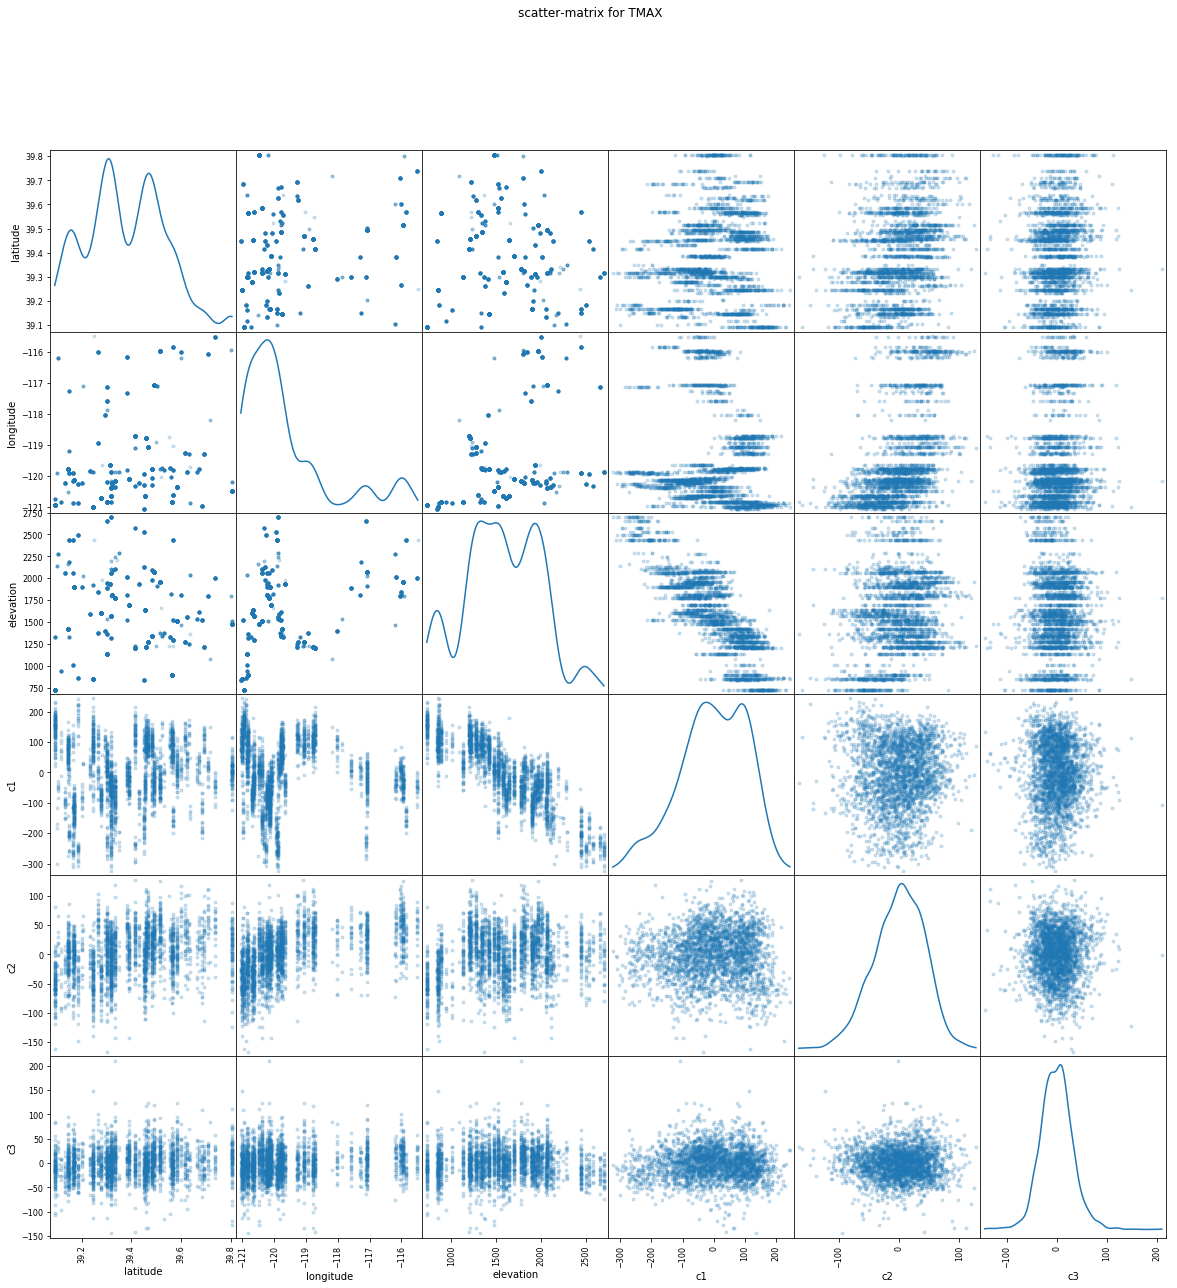

SELECT SNOW.latitude,SNOW.longitude,SNOW.elevation,SNOW.coeff_1 c1,SNOW.coeff_2 c2,SNOW.coeff_3 c3
FROM weather_SNOW SNOW
WHERE measurement='SNOW'
SNOW has valid data count:1119


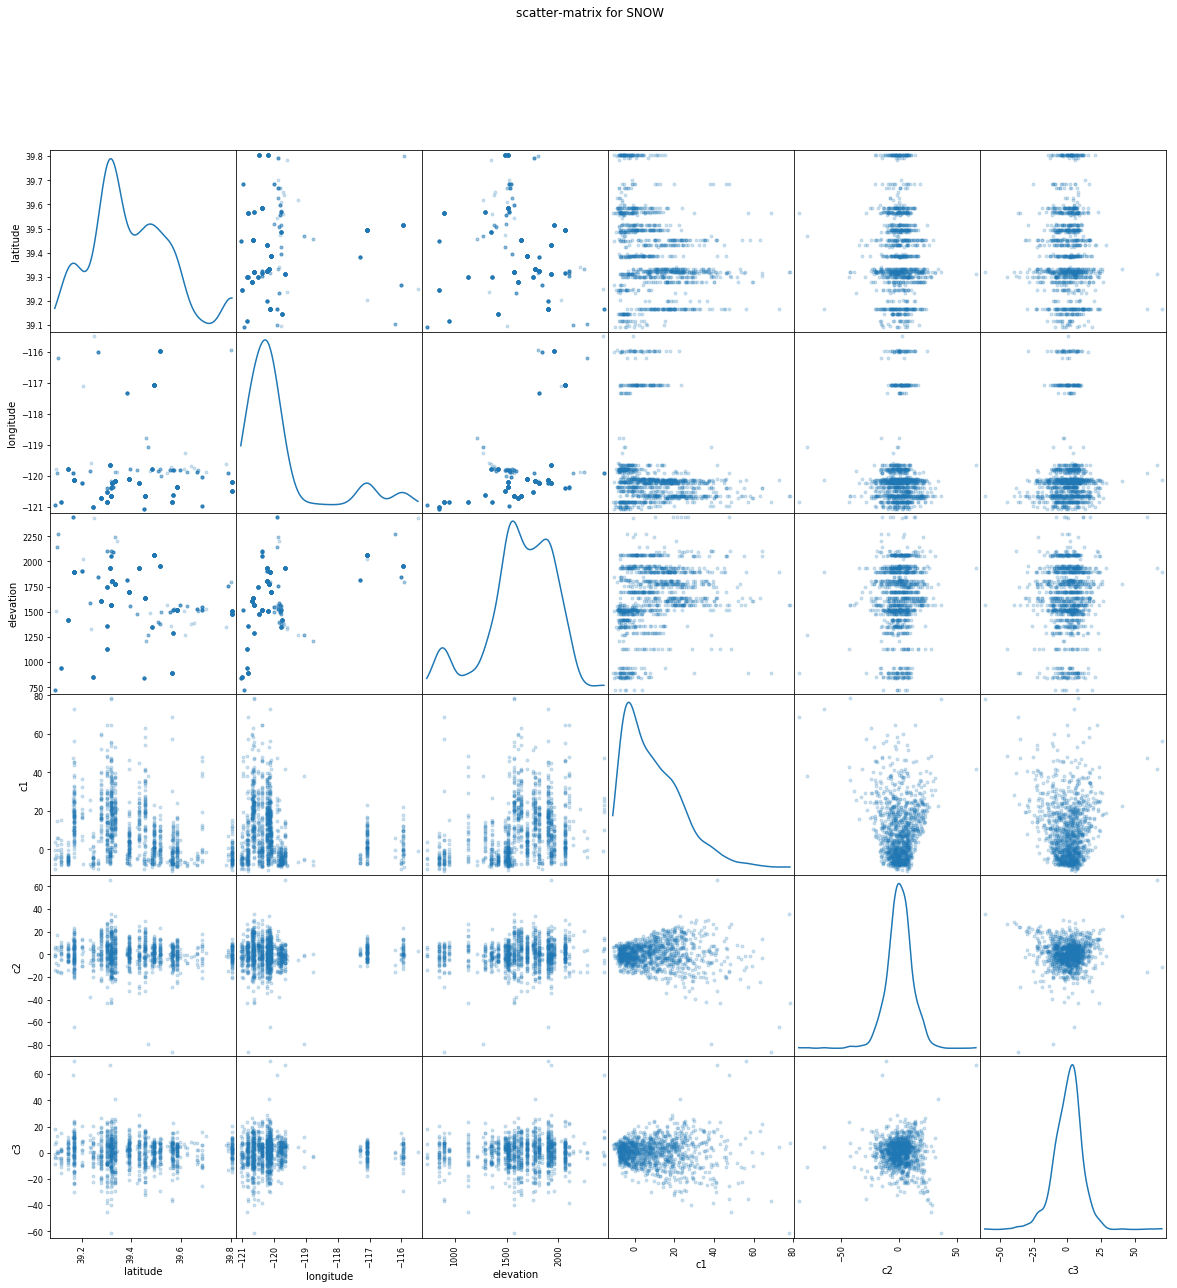

SELECT SNWD.latitude,SNWD.longitude,SNWD.elevation,SNWD.coeff_1 c1,SNWD.coeff_2 c2,SNWD.coeff_3 c3
FROM weather_SNWD SNWD
WHERE measurement='SNWD'
SNWD has valid data count:517


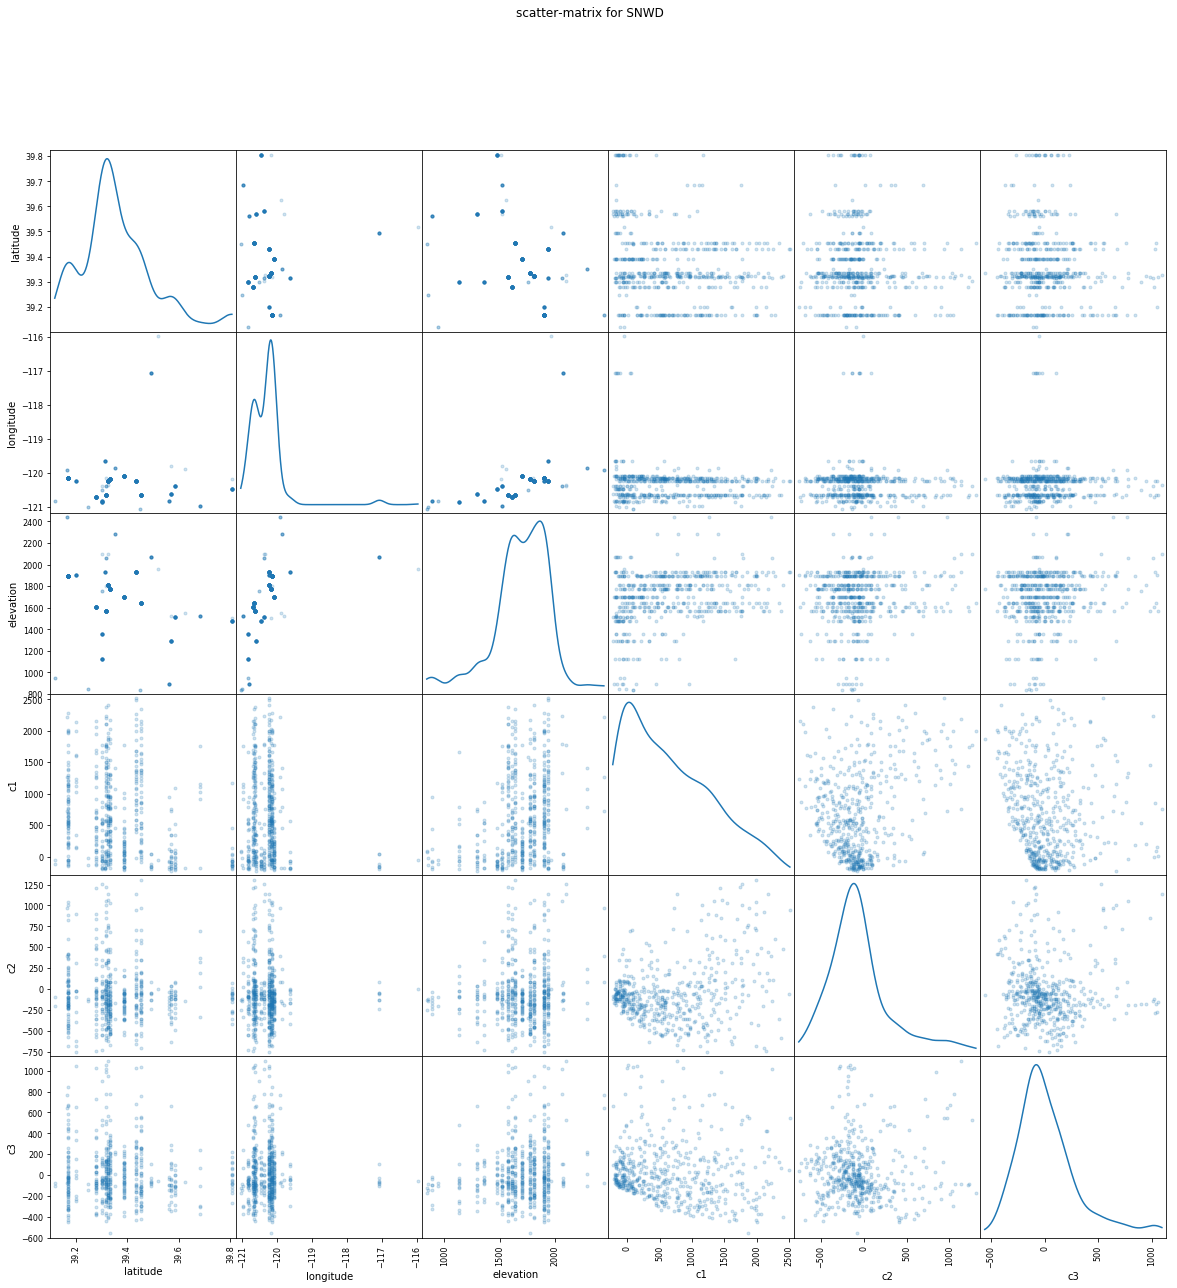

SELECT PRCP.latitude,PRCP.longitude,PRCP.elevation,PRCP.coeff_1 c1,PRCP.coeff_2 c2,PRCP.coeff_3 c3
FROM weather_PRCP PRCP
WHERE measurement='PRCP'
PRCP has valid data count:1694


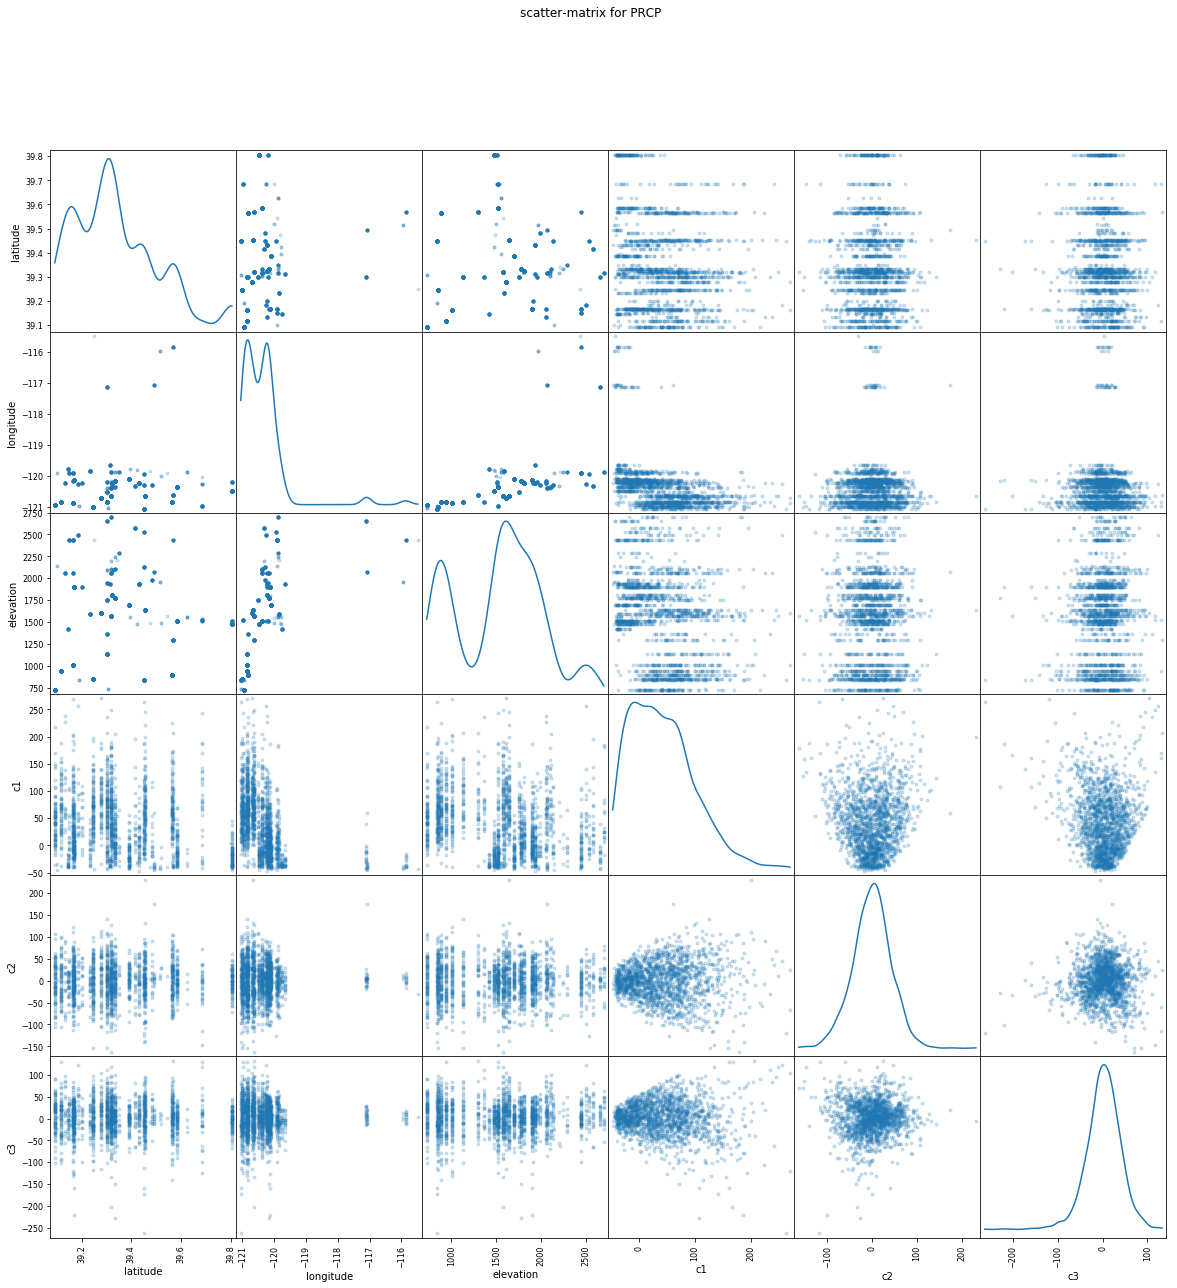

In [80]:
# We want to select samples of (year,station) pair that we have all 6 measurements in the year for the station.
# Basically, we join the 6 measurement tables on having same year and station
df_meas = {}
for m in ['TMAX','SNOW','SNWD',"PRCP"]:
    query = 'SELECT %s.latitude,%s.longitude,%s.elevation,%s.coeff_1 c1,%s.coeff_2 c2,%s.coeff_3 c3' %(m,m,m,m,m,m)
    query += "\nFROM weather_%s %s"%(m,m)
    query += "\nWHERE measurement='%s'"%(m)
    print query
    dfm = sqlContext.sql(query)
    df_meas[m] = dfm.toPandas()
    print("%s has valid data count:%d"%(m,len(df_meas[m])))
    scatter_matrix(df_meas[m],alpha=0.2,figsize=(20, 20), diagonal='kde')
    plt.suptitle('scatter-matrix for %s'%(m))
    plt.show()